# Order Book Analysis <br>

Data Provided is L2 Order book Data. <br>
Simple Insight that can be generated from Order book: <br>
&emsp; 1) Price and Volume of Limit Orders <br>
&emsp; 2) Total Volume present at a given snapshot (bid/ask) <br>
&emsp; 3) Mid-Price, Average Volume <br>
&emsp; 4) Liquidity in the Market based on Price and Volume <br>
&emsp; 5) Market Depth - Information about Supply and Demand <br>
&emsp; 6) VWAP Calculation <br>
&emsp; 7) OFI- Order Flow Imbalance- quantification of supply and demand inequalities <br>
&emsp; 8) Order Wall in the Order Book<br>


There are some ineeficiencies in the order book, which we are trying to explore as well: <br>
&emsp; 1) Order Book is improper- BS < AS <br>
&emsp; 2) Order Book is illiquid- Not enough volume <br>
&emsp; 3) Spread are too high- Illiquid <br>
&emsp; 4) Malicious Order in Order book <br> 

Anomalies which can be there in order book: <br>
&emsp; 1) Price Anamoly - Rate of Return/Price is inconsistent <br>
&emsp; 2) Volume Anamoly - Volume is low/inconsistent <br>
&emsp; 3) Spread Anamoly - Spread too high/low <br>
&emsp; 4) Order Anamoly - Illiquid Market, Very Few Orders during specific times <br>

**Note:** I am making an assuption that most process in Order Book follows an Guassian Distrbution- as according to Efficient Market Hypothesis, Market always behaves in random manner, and follows a guassian distrbution. 

In [429]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
%matplotlib inline
import seaborn
sns.set()

In [182]:
# Merging all txt file into one
filenames = ['XBTUSD/XBTUSD_20190211.txt', 'XBTUSD/XBTUSD_20190212.txt','XBTUSD/XBTUSD_20190213.txt','XBTUSD/XBTUSD_20190214.txt','XBTUSD/XBTUSD_20190215.txt']
with open('XBTUSD/merged_XBTUSD.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())

### Data Wrangling
Converting the `.txt` file into Pandas DataFrame for processing in Python <br>
Coverting Json - into Pandas <br>

Table Format: <br>
`index | price | side | snapshot | timestamp | volume` <br>

In [376]:
# Converting the .txt data to pandas dataframe

data = []
for line in open("XBTUSD/merged_XBTUSD.txt"):
    split = line.split(': ')
    ss = split[0].rstrip(" +0000 UTC")
    book = json.loads(split[1])[1]

    asks = [{'snapshot': ss, 'price': i[0], 'volume': i[1], 'timestamp': i[2], 'side': 'as'} for i in book['as']]
    bids = [{'snapshot': ss, 'price': i[0], 'volume': i[1], 'timestamp': i[2], 'side': 'bs'} for i in book['bs']]
    
    data += asks + bids

df = pd.DataFrame(data)
df['snapshot'] = pd.to_datetime(df['snapshot'], utc=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
df['price'] = pd.to_numeric(df['price'])
df['volume'] = pd.to_numeric(df['volume'])
df.index = df.timestamp
#df = df.sort_index()

**Description of DataFrame** <br>
By using df.describe- we get the `mean, std, max, top 25,50,75% percentile` values <br>


In [377]:
df.describe()

,price,volume
count,399200.000000,3.992000e+05
mean,3581.311235,4.354205e+00
std,30.058180,8.966663e+00
min,3500.000000,1.000000e-08
25%,3559.900000,1.402164e-01
50%,3579.500000,2.000000e+00
75%,3602.400000,5.000000e+00
max,3700.000000,2.216794e+02


In [ ]:
#df.tail()

**Finding Redundant Data**: <br>
In the given Data Set, there will be lot of redundant values, because the limit order which is not filled will be repeated in the Order Book again. <br>
Redundant Data will be `price, side, volume, timestamp` as it will be present over different `Snapshot` <br>

In [378]:
# Redundant data 
df_redundant = df[df.duplicated(subset=["price", "side", "volume", "timestamp"], keep='first')]
df_redundant.shape

(237168, 5)

**Removing Redundant Data**<br>
We are removing the Redundant Data from the DataSet <br>

In [379]:
# Removing redundancy from the Data
df_clean = df.drop_duplicates(subset=["price", "side", "volume", "timestamp"], keep='first')
df_clean.shape

(162032, 5)

### Filling Missing Values with 0
Trying to find if there is any missing data, and if yes- fill it with 0 <br>
From testing - *No missing data Found* <br>

In [382]:
#Getting the missing data
def missing_data(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [383]:
missing_df = missing_data(df)
print(missing_df)

           Total  Percent
volume         0      0.0
timestamp      0      0.0
snapshot       0      0.0
side           0      0.0
price          0      0.0


### Plotting Bid/Ask on the limit order book
Plot to See where the the Orders lies in order book data, with respect to each other <br>

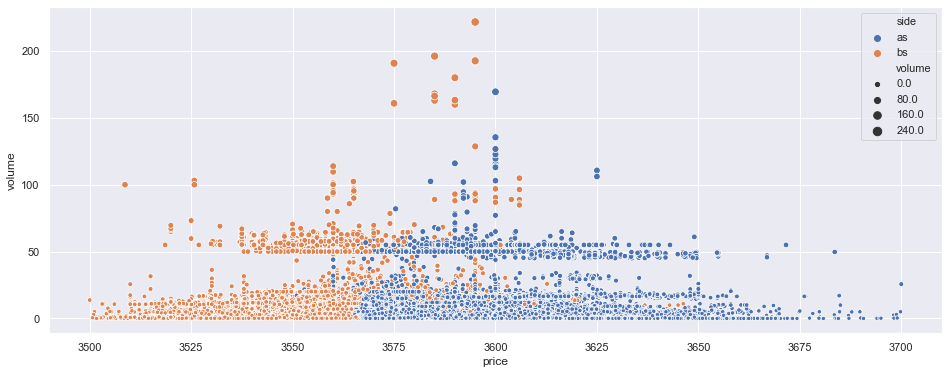

In [188]:
# Plotting the DataSet Volume vs Price 
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="price", y="volume", size="volume", hue="side", data=df_clean)
ax

In above plot, most bid lies on left side, and ask on right side. Which shows there isn't a big price action on the given dates.<br> 


In [ ]:
df_clean['size'] = df_clean['volume']*df_clean['price']
df_clean['day'] = df_clean.index.day
df_clean['hour'] = df_clean.index.hour
#df_clean.head()

## Finding Anamoly on Volume and Price

 1) Grouping Data by Daily- to find inconsistent Price or Volume on daily basis <br>
 2) Grouping Data by Hously to find inconsistent Price or Volume on hourly basis <br>

In [239]:
# Grouping the Data by Day - We see there is low volume on day 9, and 10th
df_clean.groupby(['day', 'side']).agg({'price': 'mean', 
                                               'size':'sum', 
                                               'volume':'sum'})

price          size        volume
day side                                         
9   as    3686.190000  1.047889e+05     28.399000
    bs    3550.200000  1.775100e+04      5.000000
10  as    3673.505882  4.629649e+05    126.077460
    bs    3577.429592  1.139227e+06    317.436069
11  as    3608.002341  2.703150e+08  74841.814254
    bs    3584.460880  3.094223e+08  86366.616396
12  as    3590.275046  2.419761e+08  67345.015341
    bs    3567.362487  2.756653e+08  77312.467460
13  as    3593.495676  2.415916e+08  67179.511898
    bs    3572.741489  3.239732e+08  90736.117139
14  as    3579.718888  2.742111e+08  76540.148290
    bs    3560.386235  3.039411e+08  85413.599920
15  as    3582.115581  2.641750e+08  73687.142046
    bs    3560.823899  3.083174e+08  86621.422557

**Daily Price/Volume Analysis** <br>
In above data, there is **low volume** on `9` and `10` compared to volume on any other day. It's an anamoly.<br>
The anamoly above is clearly visible. For larger Data Set- we can use Isolation Forest/SVM/K-means to find anamolies. 

In [335]:
#Abnormaly High Trading Volume - Grpup by Hourly - We didn't find any abnormal price or volume
df_hourly = df_clean.groupby(['hour','side']).agg({'price': 'mean', 
                                               'size':'sum', 
                                               'volume':'sum'})
print(df_hourly)

                 price          size        volume
hour side                                         
0    as    3596.314969  5.790958e+07  16088.600815
     bs    3570.591248  7.112614e+07  19929.699516
1    as    3594.090996  4.968860e+07  13809.349701
     bs    3572.382026  6.990429e+07  19576.316025
2    as    3592.736208  4.994867e+07  13890.579732
     bs    3573.735755  5.561883e+07  15561.952521
3    as    3593.334645  5.148840e+07  14317.170808
     bs    3573.250733  5.346952e+07  14965.445411
4    as    3594.090992  5.210845e+07  14485.140682
     bs    3573.130844  5.680278e+07  15904.852082
5    as    3594.019462  4.995465e+07  13891.614746
     bs    3572.435097  6.191155e+07  17338.436775
6    as    3596.694058  4.907282e+07  13635.576410
     bs    3574.110306  6.087607e+07  17039.965620
7    as    3591.425699  4.842269e+07  13470.428995
     bs    3570.906061  5.382308e+07  15082.337905
8    as    3589.170245  5.137522e+07  14296.933458
     bs    3569.364234  6.05945

**Hourly Price/Volume Analysis**<br>
In above Hourly data for Price and volume - both lies in well defined range, and there is no anamoly in the the price and volume on hourly basis

### Converting the Data into Pandas - Different Format 
Converting Data in `.txt` file into pandas, in following format for futher analysis:<br>
`snapshot| ap1 | ap2 .... | ap100| av1| av2 .....|av100| bp1 | bp2 ..... bp100 | bv1| bv2.....bv100`

In [494]:
# Converting the Txt file in different Pandas Format for more Analysis
df_new = pd.DataFrame()
snapshot = []
ap = []
av = []
bp = []
bv = []
for line in open("XBTUSD/merged_XBTUSD.txt"):
    split = line.split(': ')
    ss = split[0].rstrip(" +0000 UTC")
    book = json.loads(split[1])[1]
    snapshot.append(ss)
    ap_temp = []
    av_temp = []
    bp_temp = []
    bv_temp = []
    for i in range(0,100):
        ap_temp.append(book['as'][i][0])
        av_temp.append(book['as'][i][1])
        bp_temp.append(book['bs'][i][0])
        bv_temp.append(book['bs'][i][1])
    ap.append(ap_temp)
    av.append(av_temp)
    bp.append(bp_temp)
    bv.append(bv_temp)

ap = np.asarray(ap)
bp = np.asarray(bp)
av = np.asarray(av)
bv = np.asarray(bv)

ap = np.transpose(ap)
bp = np.transpose(bp)
av = np.transpose(av)
bv = np.transpose(bv)

df_new['snapshot'] = snapshot

for i in range(100):
    ap_str = 'ap'+str(i)
    bp_str = 'bp'+str(i)
    av_str = 'av'+str(i)
    bv_str = 'bv'+str(i)
    df_new[ap_str] = ap[i]
    df_new[ap_str] = df_new[ap_str].astype(float)
    df_new[bp_str] = bp[i]
    df_new[bp_str] = df_new[bp_str].astype(float)
    df_new[av_str] = av[i]
    df_new[av_str] = df_new[av_str].astype(float)
    df_new[bv_str] = bv[i]
    df_new[bv_str] = df_new[bv_str].astype(float)
    
df_new['snapshot'] = pd.to_datetime(df_new['snapshot'], utc=True)
df.index = df.snapshot
df_new['midprice'] = (df_new['ap0']+df_new['bp0'])/2
df_new['spread'] = (df_new['ap0'] - df_new['bp0'])/2

In [337]:
#df_new.head()

#### Order Book Consistency Check
Checking if Bid Price is lower than Ask Price in the Order Book or not<br>
No Inconsitency found from the test<br>

In [422]:
# Order Sanity Check - All BS<AS - No Inconsistency found in Order Book
bs_as_comparison= df_new['bp0'] < df_new['ap0']
for item in bs_as_comparison:
    if item == False:
        print('Order Book Inconsitency')


## Order Analysis

The Orders in order book follows a Gaussian Distrbution, around the mid-point. 
Below I am verifying if the order book  forms a Guassian Distribution around mid-point. 

In [339]:
# Creating Histogram of Orders 
df_hist = pd.DataFrame()
price_diff = []
volume = []
for i in range(100):
    ap_str = 'ap'+str(i)
    bp_str = 'bp'+str(i)
    av_str = 'av'+str(i)
    bv_str = 'bv'+str(i)
    
    price_diff.append((df_new['midprice']-df_new[ap_str]).values)
    volume.append(df_new[av_str].values)
    price_diff.append((df_new['midprice']-df_new[bp_str]).values)
    volume.append(df_new[bv_str].values)

volume = [item for sublist in volume for item in sublist]
price_diff = [item for sublist in price_diff for item in sublist]
df_hist = pd.DataFrame()
df_hist['price_diff'] = price_diff
df_hist['volume'] = volume
df_hist = df_hist.sort_values('price_diff')

In [340]:
#df_hist.head()

<module 'seaborn' from 'C:\\Users\\rohit\\Anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

<Figure size 1728x2160 with 0 Axes>

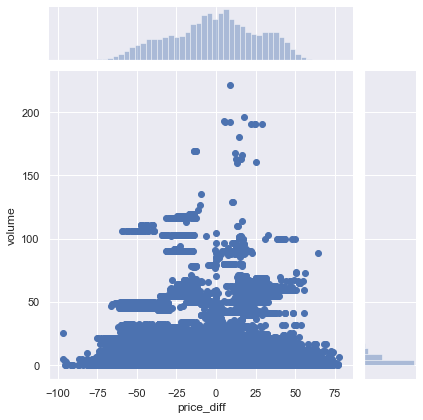

In [342]:
plt.figure(figsize=(24, 30))
sns.jointplot(x=df_hist['price_diff'], y=df_hist['volume'])
sns

**Order Analysis**<br>
In above Chart, the orders forms a Guassian Distrbution around the Mid-Price.<br>
The Top Chart in above shows the distribution of Orders in Order Book around Mid-Price<br>

## Spread, Volatility, and Volume Relation

In order book there is loose relation between *Spread, Volume, and Volatility*. <br>
I am trying to find a correlation between spread, volume and volatility

In [399]:
# Average Spread vs Volatility - Checking if the spread is higher during higer volatility 
df_new['volatility'] = df_new['midprice'].pct_change().rolling(50).std()
df_new['ma_spread'] = df_new['spread'].rolling(50).mean()

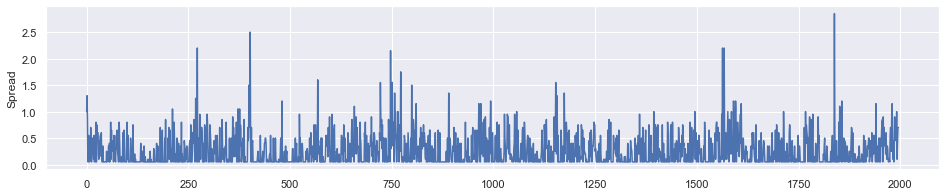

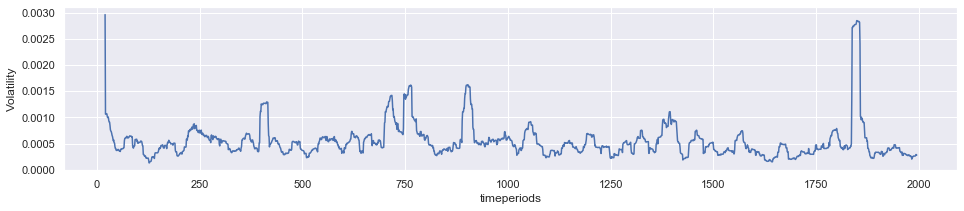

In [394]:
# From the Chart Below, we can find that there is anamoly in `Spread` -It's not consistent- There is an anomoly on spread
plt.figure(figsize=(16, 3))
plt.plot(df_new['spread'])
plt.ylabel('Spread')
plt.show()
plt.figure(figsize=(16, 3))
plt.plot(df_new['volatility'])
plt.xlabel('timeperiods')
plt.ylabel('Volatility')
plt.show()


**Plot Analysis**<br>
In Above Graph- It's hard to find any relation between Spread and Volatility above, as Spread data is quite noisy. <br>
We can Smoothen the Spread Data by using *Simple Moving average* (We can also use, *Kalman Filter*, or *EMA*)

In [395]:
# Aggregate Volume at Each Snapshot
total_vol = []
for i in range(len(df_new)):
    vol = 0
    for j in range(100):
        av_str = 'av'+str(j)
        bv_str = 'bv'+str(j)
        vol+= (df_new[av_str].iloc[i] + df_new[bv_str].iloc[i])
    total_vol.append(vol)
df_new['agg_vol'] = total_vol
#df_new.head()

In [400]:
df_new['ma_agg_vol'] = df_new['agg_vol'].rolling(50).mean()

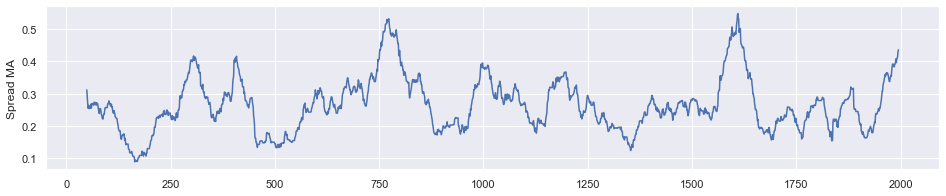

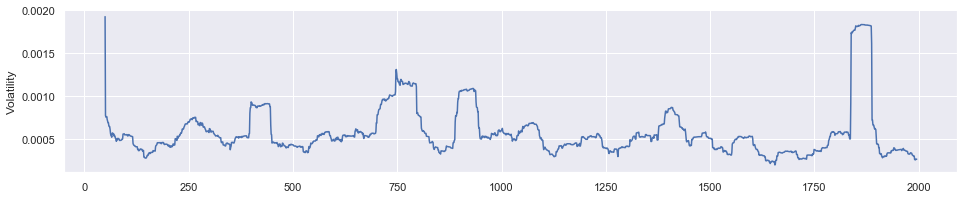

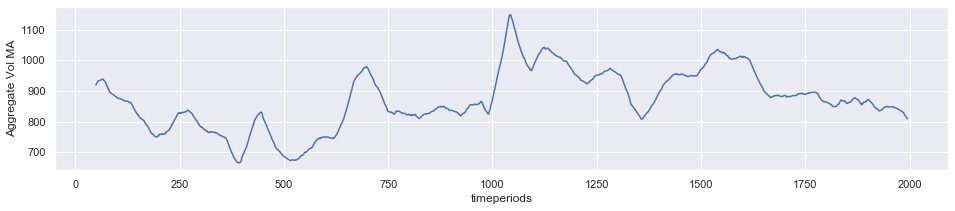

In [401]:
# Plotting to draw Relation Between Speard MA, Volatility, Volume
plt.figure(figsize=(16, 3))
plt.plot(df_new['ma_spread'])
plt.ylabel('Spread MA')
plt.show()
plt.figure(figsize=(16, 3))
plt.plot(df_new['volatility'])
plt.ylabel('Volatility')
plt.show()
plt.figure(figsize=(16, 3))
plt.plot(df_new['ma_agg_vol'])
plt.ylabel('Aggregate Vol MA')
plt.xlabel('timeperiods')
plt.show()

In [402]:
# Correlation among MA_Spread and Volatility- There is Low Correlation Among MA_Spread 
df_corr = pd.DataFrame()
df_corr['ma_spread']  = df_new['ma_spread']
df_corr['ma_agg_vol']    = df_new['ma_agg_vol']
df_corr['volatility'] = df_new['volatility']

df_corr = df_corr.corr()
print(df_corr)

            ma_spread  ma_agg_vol  volatility
ma_spread    1.000000    0.226226    0.240272
ma_agg_vol   0.226226    1.000000   -0.083730
volatility   0.240272   -0.083730    1.000000


#### Analysis on Spread, Volume and Volatility 
From above chart, and correlation analysis, <br>
&emsp; 1) Volatility is loosly correlated with Spread (Fit's with Hypothesis, as if the Spread is big, mid-price movement will be higher)<br>
&emsp; 2) Volume is loosly correlated with Spread (Doesn't fit with Hypothesis) <br>
&emsp; 3) Volume is Anti-Correlated with Volatility- Which is consistent with hypothesis <br> 

In an fully efficient market:<br>
&emsp; 1) Higher Spread implies there is Lower Volume around Mid-Price(Liquidity Issues)<br>
&emsp; 2) HIgher Spread -> Higher Volatility, as the mid-price movement will be higher if the price makes a move on either side <br>
&emsp; 3) Lower Volume -> Higher Volatility, as with lower volume, any order will move up across the order book <br>


## Anamoly on Spread

From the above chart- spread data have few anamolies. For an efficient Order Book, the spread should be low and consistent <br> Below I am trying to find the anamolies in Spread of the Order Book <br>
Two Methods used to find the Anamolies in Spread: <br>
1) **Isolation Forests** -It detects anomalies purely based on the fact that anomalies are data points that are few and different <br>
2) **SVM** - A SVM is typically associated with supervised learning, but OneClassSVM can be used to identify anomalies as an unsupervised problems that learns a decision function for anomaly detection: classifying new data as similar or different to the training set <br>

In [347]:
# Anomoly on Spread - Isolation Forests For Anomaly Detection
data = df_new[['spread']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
outliers_fraction = 0.01
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df_new['anomaly2'] = pd.Series(model.predict(data))
#df_new.head()

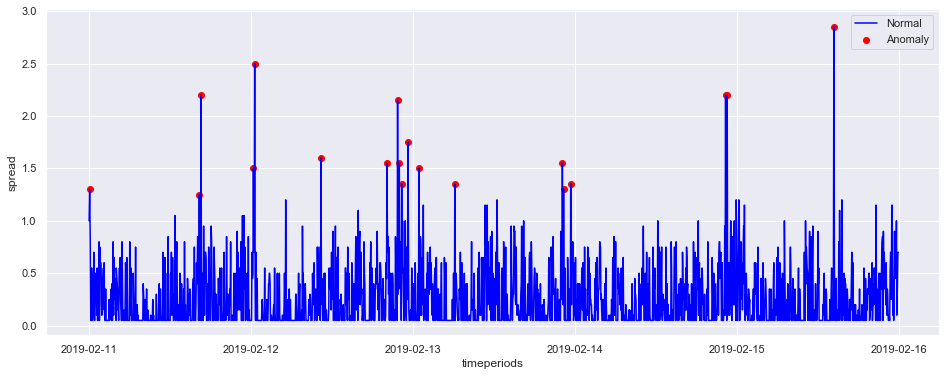

In [406]:
plt.figure(figsize=(16, 6))
a = df_new.loc[df_new['anomaly2'] == -1, ['snapshot', 'spread']] #anomaly
plt.plot(df_new['snapshot'], df_new['spread'], color='blue', label = 'Normal')
plt.scatter(a['snapshot'],a['spread'], color='red', label = 'Anomaly')
plt.legend()
plt.ylabel('spread')
plt.xlabel('timeperiods')
plt.show()

In [349]:
# Using SVM - OneClassSVM to find the anamoly in the data
df_new_reindexed = df_new.reset_index()
data = df_new_reindexed[['spread','index']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
from sklearn.svm import OneClassSVM

model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
model.fit(data)
df_new_reindexed['anomaly3'] = pd.Series(model.predict(data))



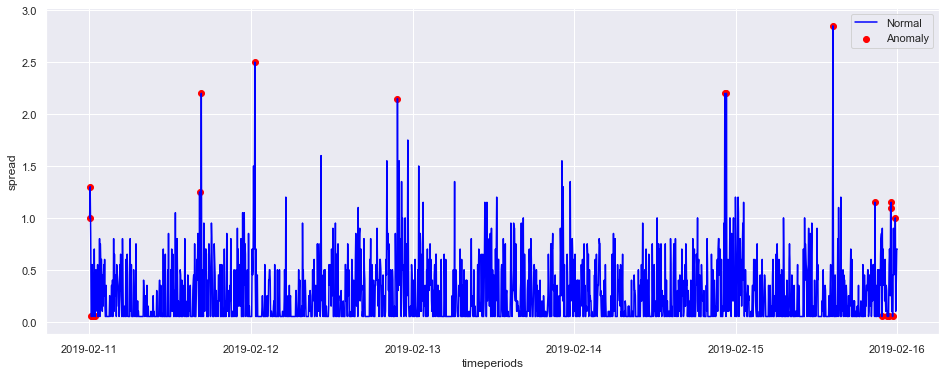

In [407]:
plt.figure(figsize=(16, 6))
a = df_new_reindexed.loc[df_new_reindexed['anomaly3'] == -1, ['snapshot', 'spread']] #anomaly
plt.plot(df_new_reindexed['snapshot'], df_new_reindexed['spread'], color='blue', label = 'Normal')
plt.scatter(a['snapshot'],a['spread'], color='red', label = 'Anomaly')
plt.legend()
plt.ylabel('spread')
plt.xlabel('timeperiods')
plt.show()

#### Analysis - Anamoly detection on Spread

1) In case of Isolation Forests, we only got anamoly on Spread, which were higher. As these were more outliers<br>
2) In case of SVM - we found the Anamoly at lowest Spread as well. <br>

As lower spread is good for Market- we can utilize the result from Isolation forest and create a log of the preiods where spread is high. <br>

## Market Depth Analysis 

#### Market Depth vs Volatility

Testing the relation between Market Depth and Volatility <br>

Calculation of Market Depth:<br>
```
for each i in level 0-100:    
    depth += (price(i)*volume(i)) * [1-decay_factor*i]
```        
decay_factor = `0.01`, as we want to give less weitage to the orders which exists deep in the order book

In [387]:
#Market Depth vs Volatility
total_depth = []
for i in range(len(df_new)):
    depth = 0
    for j in range(100):
        ap_str = 'ap'+str(j)
        bp_str = 'bp'+str(j)
        av_str = 'av'+str(j)
        bv_str = 'bv'+str(j)
        depth+= ((df_new[av_str].iloc[i]*df_new[ap_str].iloc[i] + df_new[bv_str].iloc[i]*df_new[bp_str].iloc[i]) * (1-0.01*j))
    total_depth.append(depth)
df_new['depth'] = total_depth


In [408]:
#df_new.head()
df_new['ma_depth'] = df_new['depth'].rolling(50).mean()

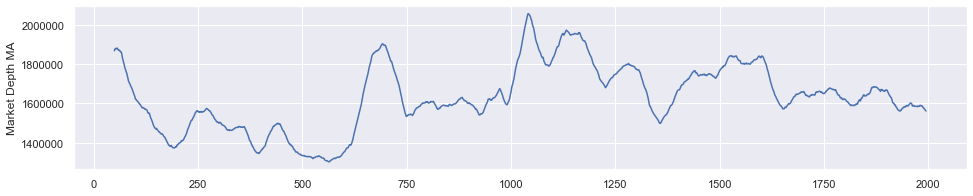

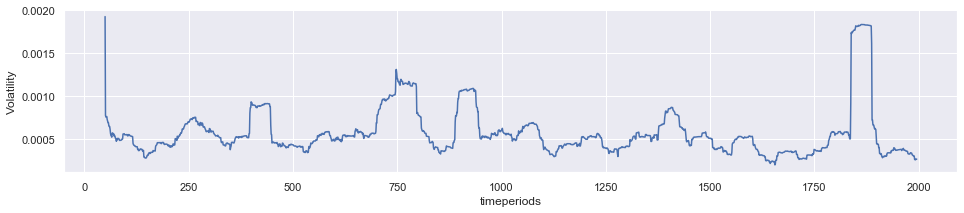

In [409]:
# From the Chart Below, we can find that there is anamoly in `Spread` -It's not consistent- There is an anomoly on spread
plt.figure(figsize=(16, 3))
plt.plot(df_new['ma_depth'])
plt.ylabel('Market Depth MA')
plt.show()
plt.figure(figsize=(16, 3))
plt.plot(df_new['volatility'])
plt.xlabel('timeperiods')
plt.ylabel('Volatility')
plt.show()

In [410]:
df_corr = pd.DataFrame()
df_corr['volatility'] = df_new['volatility']
df_corr['depth_ma'] = df_new['depth_ma']
df_corr = df_corr.corr()
print(df_corr)

            volatility  depth_ma
volatility    1.000000 -0.046227
depth_ma     -0.046227  1.000000


**Market Depth vs Volatility Analysis**

Market Depth is loosly- Inversely correlated to Volatility- Which is consistent with Hypothesis. As there is more depth in the order book, theortically the volatility should be lower.<br> 
For confirming the hypothesis, that Depth is Inversely Correaled to Volatility, we need much closer relationship.<br>

### Market Depth Distribution
In efficient Market- Market Depth should follow Guassian Distrbution<br>
Test below confirms hypothesis- Market Depth follows Normal Distrbution<br>

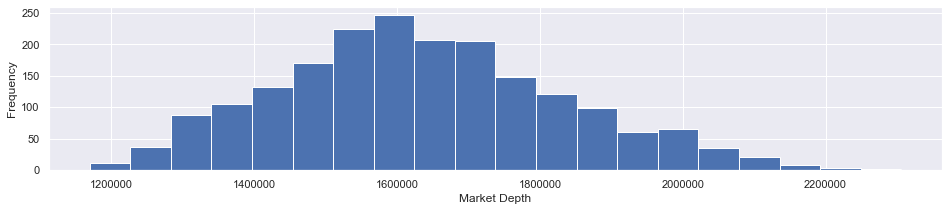

In [434]:
#Finding Market Depth distribution
plt.figure(figsize=(16, 3))
plt.hist(df_new['depth'],bins=20)
plt.xlabel('Market Depth')
plt.ylabel('Frequency')
plt.show()


Market Depth Forming a Guassian Distrbution

## Rate of Return Analysis
Similar to Market Depth, Rate of Return also forms a guassian distribution<br>
Test Below Confirms the hypothesis<br>

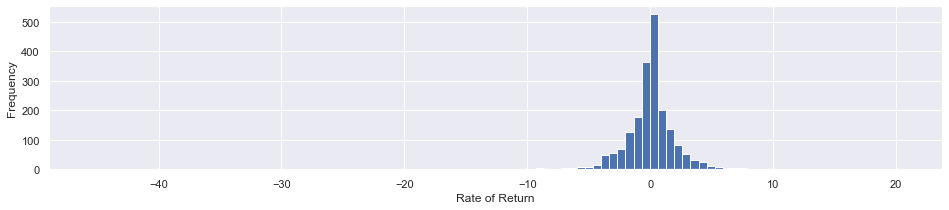

In [440]:
df_new['ror'] = df_new['midprice']-df_new['midprice'].shift(1)
plt.figure(figsize=(16, 3))
plt.hist(df_new['ror'],bins=100)
plt.xlabel('Rate of Return')
plt.ylabel('Frequency')
plt.show()

Rate of Return on price Forming a Guassian Distrbution

### Anamoly on Rate of Return
In the example below we are trying to find if there is an anamoly/outlier in the Rate of Returns <br>
For simplicity- We assume Rate of Return follows a simple Guassian Structure- hence ourliers are tiny<br>

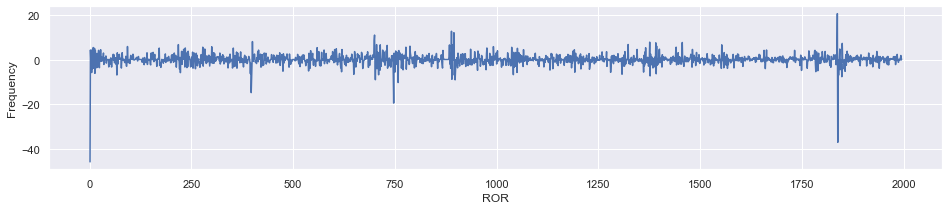

In [438]:
#Plotting Rate of Returns
plt.figure(figsize=(16, 3))
plt.plot(df_new['ror'])
plt.xlabel('ROR')
plt.ylabel('Frequency')
plt.show()

In [443]:
# Anamoly detection onf Rate of Returns- Isolation Forests For Anomaly Detection
df_new = df_new.fillna(0)
data = df_new[['ror']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
outliers_fraction = 0.01
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df_new['anomaly_ror'] = pd.Series(model.predict(data))

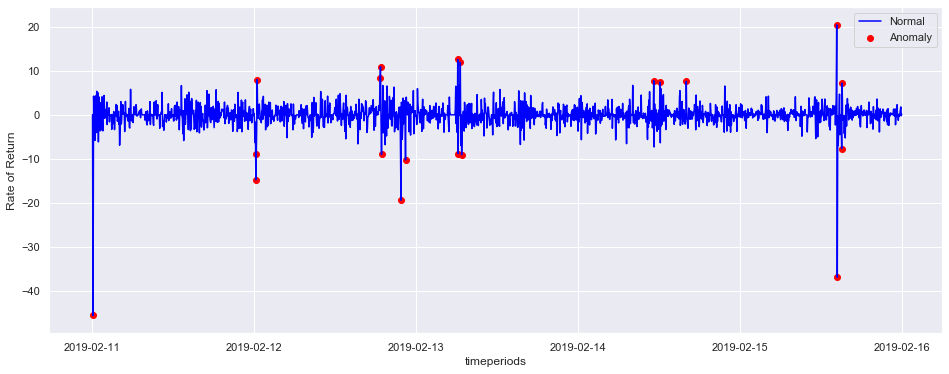

In [444]:
plt.figure(figsize=(16, 6))
a = df_new.loc[df_new['anomaly_ror'] == -1, ['snapshot', 'ror']] #anomaly
plt.plot(df_new['snapshot'], df_new['ror'], color='blue', label = 'Normal')
plt.scatter(a['snapshot'],a['ror'], color='red', label = 'Anomaly')
plt.legend()
plt.ylabel('Rate of Return')
plt.xlabel('timeperiods')
plt.show()

Above Diagram shows the outlier/anamoly in the rate of returns

## Order Flow Imbalance (OFI)

It's quantification of supply and demand inequalities in a LOB during a given time frame<br>
We are trying to find the imbalance of Order Flow, which is dictated by Price Movement <br>

In [485]:
def OFI(df_new, timeframe):
    
    qdf = df_new
    #qdf = qdf.set_index(['snapshot'])
    qdf['MidPriceChange'] = ((qdf['bp0'] + qdf['ap0'])/2).diff().div(0.1)
    qdf['prev_ap'] = qdf['ap0'].shift()
    qdf['prev_av'] = qdf['av0'].shift()
    qdf['prev_bp'] = qdf['bp0'].shift()
    qdf['prev_bv'] = qdf['bv0'].shift()

    qdf = qdf.fillna(0)

    ask_geq = qdf['ap0'] >= qdf['prev_ap']
    ask_leq = qdf['ap0'] <= qdf['prev_ap']
    bid_geq = qdf['bp0'] >= qdf['prev_bp']
    bid_leq = qdf['bp0'] <= qdf['prev_bp']

    qdf['OFI'] = pd.Series(np.zeros(len(qdf)))
    qdf['OFI'].loc[ask_geq] += qdf['prev_av'][ask_geq]
    qdf['OFI'].loc[ask_leq] -= qdf['av0'][ask_leq]
    qdf['OFI'].loc[bid_geq] += qdf['bv0'].loc[bid_geq]
    qdf['OFI'].loc[bid_leq] -= qdf['prev_bv'].loc[bid_leq]
  
    qdf = qdf[['MidPriceChange','OFI']]#.resample(timeframe).sum().dropna()
    qdf.name = 'OFI_df'
    return qdf

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


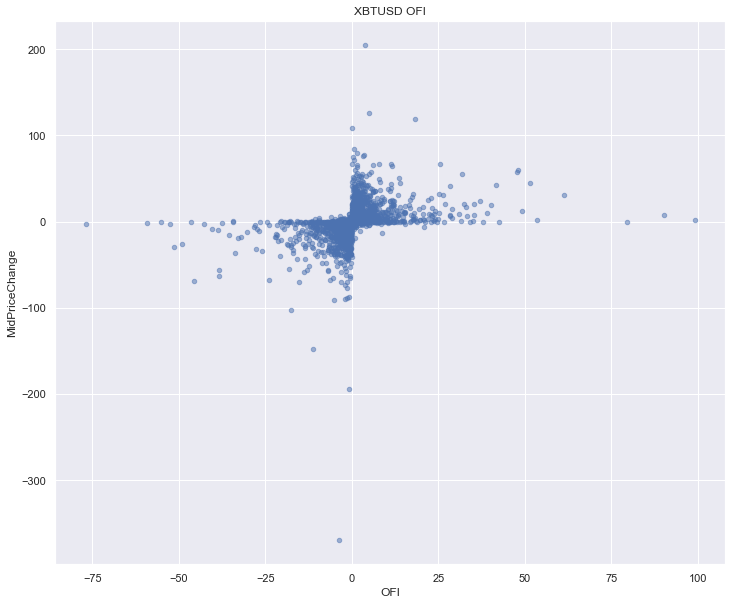

In [486]:
timeframe = 0
qdf = OFI(df_new, timeframe)
qdf.plot(kind='scatter', grid=True, 
    x='OFI', y='MidPriceChange', 
    title = 'XBTUSD'+' OFI',
    alpha=0.5, figsize=(12,10))

**Analysis**<br>
From the above figure, it seems the Order Flow is perfectly balanced for the Timeframes of given snapshots. Usually higher timeframes shows the Order Flow Imbalance. 


## Aggreagted Spread and MidPrice


In [497]:
df_new.index = df_new.snapshot
df_new['day'] = df_new.index.day
df_new['hour'] = df_new.index.hour

In [501]:
df_hourly = df_new.groupby(['hour']).agg({'spread': 'mean', 
                                           'midprice':'mean'})
print(df_hourly)

        spread     midprice
hour                       
0     0.392500  3583.640000
1     0.282558  3583.260465
2     0.234483  3583.858621
3     0.243678  3583.427586
4     0.180723  3584.230120
5     0.166471  3584.300588
6     0.229070  3584.747674
7     0.182558  3581.420930
8     0.139157  3579.480120
9     0.167262  3577.197024
10    0.318902  3576.282317
11    0.263690  3573.995833
12    0.305488  3576.693293
13    0.177439  3580.856707
14    0.279268  3579.167073
15    0.291667  3573.560897
16    0.335714  3574.477381
17    0.267089  3577.639241
18    0.261111  3581.411728
19    0.199390  3583.948171
20    0.327711  3582.738554
21    0.345732  3579.504268
22    0.448214  3576.516071
23    0.417857  3576.517857


In [502]:
df_daily = df_new.groupby(['day']).agg({'spread': 'mean', 
                                        'midprice':'mean'})
print(df_daily)

       spread     midprice
day                       
11   0.251142  3595.880330
12   0.285897  3578.735128
13   0.278304  3583.356858
14   0.259236  3570.789286
15   0.268642  3571.635802


## Summary

**Data Wrangling** <br>
Used Pandas for Data Wrangling<br>

**Data Redundancy**<br>
There was lot of or redundant data in order book, at orders which sits deep in order book don't get executed, and are repreated in the order book<br>

**Data Cleaning** <br>
I used Pandas to clean the Redundant Data<br>

**Missing Data**<br>
No missing data was found in the table. Every column was complete. <br>

**Data Accuracy** <br>
I did Bunch of Order Book Analysis to determine if the order book data is consistent.<br>
&emsp; 1) Orders in Order Book follows a Guassian Distrbution around Mid-Point<br>
&emsp; 2) Market Depth - Forms a Guassian Distrbution<br>
&emsp; 3) Order Flow Imbalance (OFI)- was consistent around Mid-Point for the smaller timeframe tested<br>
&emsp; 4) Rate of Return Forms a Gussian Distrbution<br>
&emsp; 5) Checked if BidPrice < AskPrice<br>
All the above methods tells me the data was accurate, and not much inconsistency in data. <br>
 
**Quantiatve Analysis**<br>

We grouped the Data into Hourly, and Daily (as we had few days data only):<br>
&emsp; 1) Calcuated Aggregate Volume of the order book on Daily, and Hourly basis (After cleaning the data)<br>
&emsp; &emsp; a) Found daily voume to be lower on `9th` and `10th`- need more data to test for anomalies<br>
&emsp; 2) Calcualted Avergae Price of the Orders in Order Book, on daily and hourly basis- It's Consistent <br>
&emsp; 3) Market Depth Calculation <br>
&emsp; 4) Spread Calculation - Average Spread over Hourly, Daily-  It's consistent <br>
&emsp; 5) Mid-Price - Average Mid-Price over houly, Daily - It's consistent <br>

**Qualitative Analysis**
Qualitative Analysis of Order Book: <br>
 &emsp; 1) Order Book is consistent and fair <br>
 &emsp; 2) Price didn't make a big movement- hence all the price action seems to be hovering around mid-price <br>
 &emsp; 3) Average Market Depth of Order Book is deep enough, with good volume <br>

**Anamoly Detection** <br>
Anamoly Detection on various factors:<br>
 &emsp; 1) First Anamoly was found on Aggregate Volume on day `9th` and `10th`, but due to limited data hard to test <br>
 &emsp; 2) Found anamolies in Spread- there are points where Spread was too high, and higher spread causes more slippage for users<br>
  &emsp; &emsp; a) Used Isoaltion Forest for Anamoly/Outlier Detection <br>
  &emsp; &emsp; b) Used SVM based OneClassSVM, for Anamoly detection<br>
  &emsp; &emsp; c) Results from *Isolation Forest were better*<br>
  &emsp; 3) Found Anamoly on Price - Used Isolation Forest to find the anamoly on Rate of Return<br>
  
**Relationship Among Volatility, Spread, Volume**<br>
 Summary:<br>
  &emsp;1) Volatility is loosly correlated with Spread (Fit's with Hypothesis, as if the Spread is big, mid-price movement will be higher)<br>
  &emsp; 2) Volume is loosly correlated with Spread (Shows inefficiency, as in idea scenario, it should be inversely correlated) <br>
  &emsp; 3) Volume is Anti-Correlated with Volatility- Which is consistent with hypothesis <br>

**Relationship Among Volatility, and Market Depth**<br>
Market Depth is loosly- Inversely correlated to Volatility- Which is consistent with Hypothesis. As there is more depth in the order book, theortically the volatility should be lower.<br>



## Further Work

#### Infrastrcutre Side

As the actual data will be large, and continoous, Spark(Pyspark) RDD for Data Wrangling would be more useful<br>
For Database- As the Data is Json String, we can use MongoDB, DynamoDB<br>

#### With Trades Data

Trades Data combined with Order Book I can calculate:<br>
&emsp;1) Trade Flow Imbalance<br>
&emsp;2) Possible Slippage <br>
&emsp;3) Optimal Execution for trade<br>
&emsp;4) Trade Impact on the Order Book<br>
&emsp;5) Predicting Rate of Arrival or Trades, and Mid-Price Impact of trade<br>

#### Machine Learning for Order Book Analysis

&emsp; 1) Sequencial Nueral Network can be used for mid-price movement prediction (based on Trades and Order Book, with Order book depth as features) <br>
&emsp; 2) Recurrent Nueral Network, with LTSM can also be used for prediction of mid-price movememnt. <br>
&emsp; 3) For trading we can also use Feature Extraction Algorithms like RFE, PCA for extracting only important features from Order book- usually in order book depth level upto 10, provides the most information<br>
&emsp; 4) Given large amount of Order Book and Trades Data, we can predict the probability of order getting filled in the order book<br>

Above Methods can be used to provide Liquidity, and Market Making on the exchange. <br>